In [23]:
import os
import pandas as pd
import numpy as np
import joblib
from datetime import datetime, timedelta
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
import json

# =========================
# CONFIGURATION
# =========================

In [24]:
DATA_DIR = "./data2"
os.makedirs(DATA_DIR, exist_ok=True)

# Output paths (exactly what backend expects)
MODEL_PATH = os.path.join(DATA_DIR, "global_model.pkl")
ENCODER_PATH = os.path.join(DATA_DIR, "label_encoder.pkl")
CLUSTER_PATH = os.path.join(DATA_DIR, "cluster_model.pkl")
SEGMENT_DIR = os.path.join(DATA_DIR, "segment_models")
USER_BIAS_DIR = os.path.join(DATA_DIR, "user_bias")
BOOK_XLSX = os.path.join(DATA_DIR, "book.xlsx")  # We will save processed data here

os.makedirs(SEGMENT_DIR, exist_ok=True)
os.makedirs(USER_BIAS_DIR, exist_ok=True)

# Input file (change this to your actual path)
CSV_INPUT = "book.csv"  # Place this in same folder as train.py


print("Starting Enhanced Training Pipeline...")
print(f"Loading data from: {CSV_INPUT}")

Starting Enhanced Training Pipeline...
Loading data from: book.csv


# =========================
# 1. LOAD DATA
# =========================

In [25]:
if not os.path.exists(CSV_INPUT):
    raise FileNotFoundError(f"Put your data file as '{CSV_INPUT}' in this folder!")

df = pd.read_csv(CSV_INPUT)

print(f"Loaded {len(df)} trades from {len(df['wallet'].unique())} wallets")
print(df.head())

Loaded 9956 trades from 50 wallets
                                       wallet                    timestamp  \
0  0x0000001992b50dede74101ca8a835ea7a26d5874  2024-11-01 00:27:02.000 UTC   
1  0x0000001992b50dede74101ca8a835ea7a26d5874  2024-11-01 01:08:47.000 UTC   
2  0x0000001992b50dede74101ca8a835ea7a26d5874  2024-11-01 02:03:30.000 UTC   
3  0x0000001992b50dede74101ca8a835ea7a26d5874  2024-11-01 02:46:39.000 UTC   
4  0x0000001992b50dede74101ca8a835ea7a26d5874  2024-11-01 03:19:18.000 UTC   

  in_token out_token    amount_in   amount_out  volume_usd    platform  \
0      BTC      USDT     0.004203     0.004200      383.77         okx   
1     DOGE      USDT  1959.297956  1960.143505      293.89         okx   
2     DOGE      USDT  1855.087422  1854.183310      278.26     raydium   
3      BCH      USDT     0.249240     0.249420      133.59     raydium   
4      BCH      USDT     0.873029     0.872772      467.94  pumpdotfun   

                                             tx_has

# =========================
# 2. DATA CLEANING & FEATURE ENGINEERING
# =========================

In [26]:
def engineer_features_full(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    
    # Clean timestamp
    df['timestamp'] = df['timestamp'].astype(str).str.replace(r'\.000 UTC$', '', regex=True)
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
    df = df.dropna(subset=['timestamp']).sort_values('timestamp').reset_index(drop=True)
    
    # Basic numeric fixes
    numeric_cols = ['amount_in', 'amount_out', 'volume_usd']
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce').fillna(0)
    
    # Time features
    df['time_diff'] = df.groupby('wallet')['timestamp'].diff().dt.total_seconds().fillna(3600) / 60  # minutes
    df['hour'] = df['timestamp'].dt.floor('H')
    
    # Price approximation
    df['price_in'] = np.where(df['amount_in'] > 0, df['volume_usd'] / df['amount_in'], 0)
    df['price_out'] = np.where(df['amount_out'] > 0, df['volume_usd'] / df['amount_out'], 0)
    
    # PnL estimation (next trade entry vs current exit)
    df['pnl'] = df.groupby('wallet')['price_in'].shift(-1) - df['price_out']
    df['pnl'] = df['pnl'].fillna(0)
    
    # Behavioral patterns
    df['position_change'] = df.groupby('wallet')['amount_in'].pct_change().fillna(0)
    df['price_change_pct'] = df['price_out'].pct_change().fillna(0) * 100
    df['is_win'] = df['pnl'] > 0
    
    # Streaks
    df['win_streak'] = df.groupby((df['is_win'] != df['is_win'].shift()).cumsum())['is_win'].cumsum()
    df['loss_streak'] = df.groupby((df['is_win'] != df['is_win'].shift()).cumsum())['is_win'].cumsum().where(~df['is_win'], 0)
    
    # Rolling loss/win count
    df['consecutive_losses'] = (df['pnl'] < 0).rolling(window=3, min_periods=1).sum()
    df['consecutive_wins'] = (df['pnl'] > 0).rolling(window=3, min_periods=1).sum()
    
    # Volume spike
    mean_vol = df['volume_usd'].mean()
    df['volume_spike'] = (df['volume_usd'] > mean_vol * 1.5).astype(int)

    # In train.py — add this line in clean_and_engineer()
    df['effective_leverage'] = df.get('leverage', 1) * (df['amount_in'] / df['amount_in'].shift(1).replace(0, 1))
    df['effective_leverage'] = df['effective_leverage'].fillna(1).clip(upper=50)
        
    # Final cleanup
    df['time_diff'] = df['time_diff'].clip(lower=0)
    
    return df

print("Engineering features...")
df = engineer_features_full(df)

Engineering features...


# ==========================================
# 3. EMOTION DETECTION (Rule-Based Labels)
# ==========================================

In [27]:
def detect_emotions(df: pd.DataFrame) -> pd.DataFrame:
    df['emotion'] = 'neutral'
    df['trigger_details'] = None
    
    for i in range(1, len(df)):
        prev = df.iloc[i-1]
        curr = df.iloc[i]
        
        # FOMO: Big price jump + fast trade after win
        if (curr['price_change_pct'] > 18 and 
            curr['time_diff'] < 30 and 
            prev['consecutive_wins'] >= 1):
            df.loc[i, 'emotion'] = 'fomo'
            df.loc[i, 'trigger_details'] = f"Price +{curr['price_change_pct']:.1f}% in {curr['time_diff']:.0f}m"
        
        # Revenge: Very fast trade after loss
        elif (curr['time_diff'] < 3 and prev['consecutive_losses'] >= 1):
            df.loc[i, 'emotion'] = 'revenge'
            df.loc[i, 'trigger_details'] = f"After {int(prev['consecutive_losses'])} loss(es) in {curr['time_diff']:.1f}m"
        
        # Greed: Huge size increase after wins
        elif (curr['position_change'] > 0.7 and prev['consecutive_wins'] >= 2):
            df.loc[i, 'emotion'] = 'greed'
            df.loc[i, 'trigger_details'] = f"Size up {curr['position_change']*100:.0f}% after wins"
        
        # Fear: Tiny profit taken very fast
        elif (curr['time_diff'] < 1.5 and curr['pnl'] > 0 and curr['pnl'] < 15):
            df.loc[i, 'emotion'] = 'fear'
            df.loc[i, 'trigger_details'] = f"Quick profit lock: ${curr['pnl']:.1f}"
    
    return df

print("Detecting emotions...")
df = detect_emotions(df)

# Save labeled dataset for future reference
df.to_excel(BOOK_XLSX, index=False)
print(f"Saved processed & labeled data → {BOOK_XLSX}")

Detecting emotions...
Saved processed & labeled data → ./data2\book.xlsx


# =========================
# 4. PREPARE ML DATA
# =========================

In [28]:
def prepare_ml_dataset(df: pd.DataFrame) -> tuple:
    feature_cols = [
        'time_diff', 'price_change_pct', 'position_change',
        'consecutive_wins', 'consecutive_losses', 'effective_leverage',
        'win_streak', 'loss_streak', 'volume_spike'
    ]
    
    ml_df = df[feature_cols + ['emotion']].copy()
    ml_df = ml_df.dropna()
    
    # Keep only labeled emotions (exclude neutral for training)
    ml_df = ml_df[ml_df['emotion'] != 'neutral']
    
    if len(ml_df) < 10:
        print("Not enough labeled data to train")
        return None, None
    
    X = ml_df[feature_cols].fillna(0)
    y = ml_df['emotion']
    
    return X, y

X, y = prepare_ml_dataset(df)

if X is None:
    print("Training skipped due to insufficient data")
else:
    print(f"Prepared {len(X)} training samples for training")

Prepared 3741 training samples for training


# =========================
#  VISUALIZE DATA QUALITY
# =========================

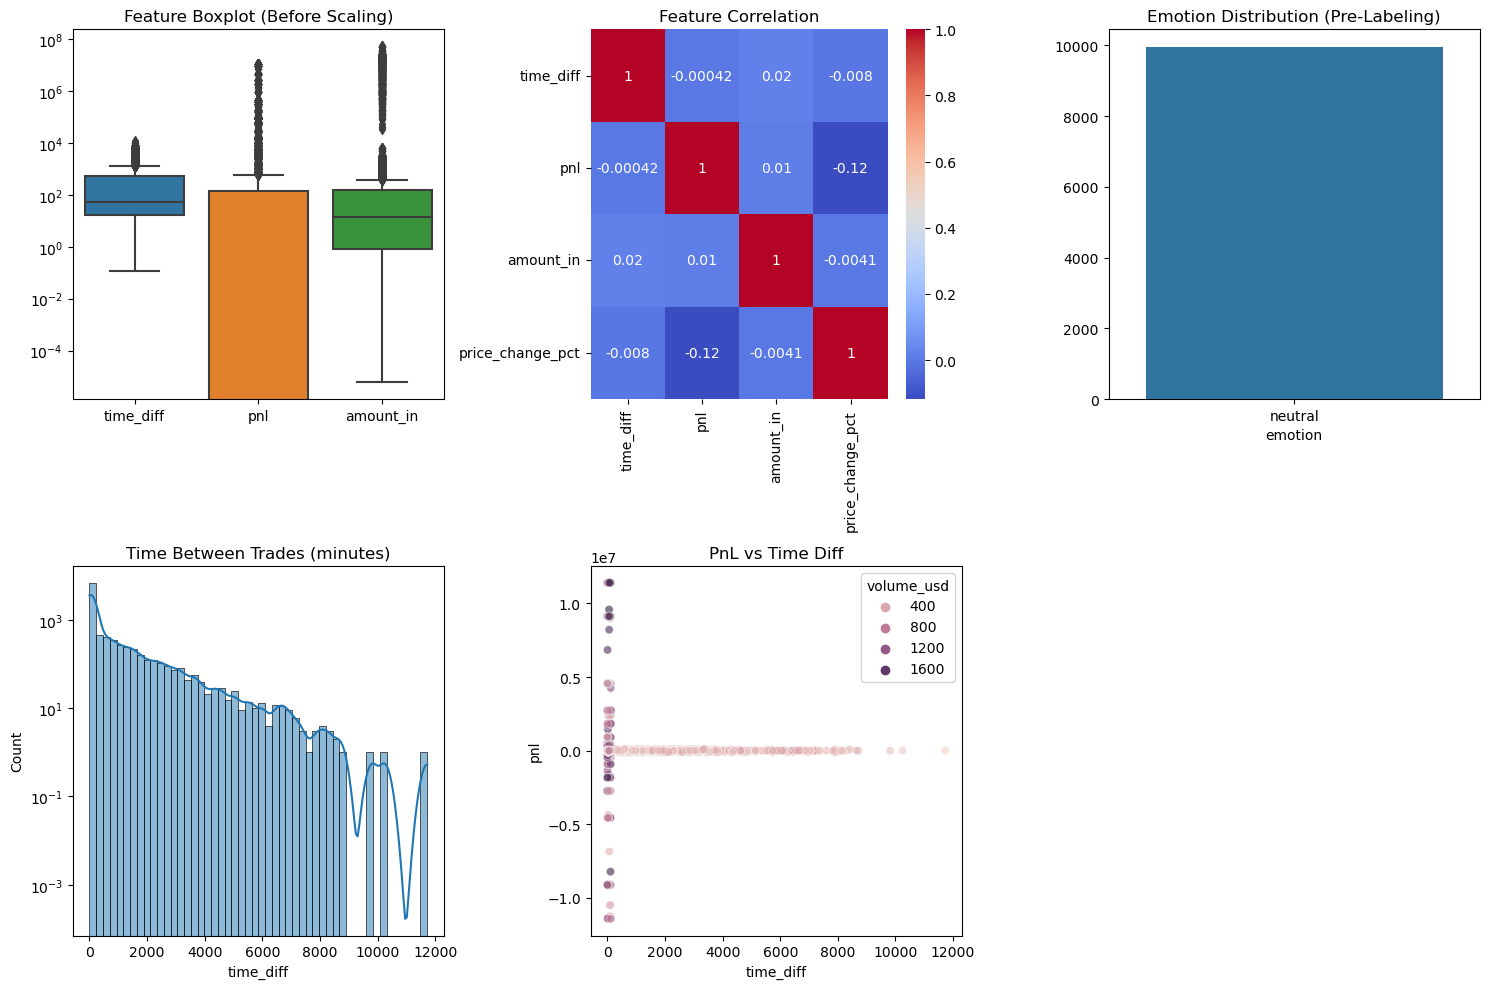

In [29]:
import os
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.cluster import KMeans
import json

plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
sns.boxplot(data=df[['time_diff', 'pnl', 'amount_in']])
plt.title("Feature Boxplot (Before Scaling)")
plt.yscale('log')

plt.subplot(2, 3, 2)
sns.heatmap(df[['time_diff', 'pnl', 'amount_in', 'price_change_pct']].corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation")

plt.subplot(2, 3, 3)
df['emotion'] = 'neutral'  # temp
emotion_counts = df['emotion'].value_counts()
sns.barplot(x=emotion_counts.index, y=emotion_counts.values)
plt.title("Emotion Distribution (Pre-Labeling)")

plt.subplot(2, 3, 4)
sns.histplot(df['time_diff'], bins=50, kde=True, log_scale=(False, True))
plt.title("Time Between Trades (minutes)")

plt.subplot(2, 3, 5)
sns.scatterplot(data=df.sample(9000), x='time_diff', y='pnl', hue='volume_usd', alpha=0.6)
plt.title("PnL vs Time Diff")

plt.tight_layout()
plt.show()

# =============================================
# 4. EMOTION DETECTION (FIXED & VISUALIZED)
# =============================================

Detecting emotions...


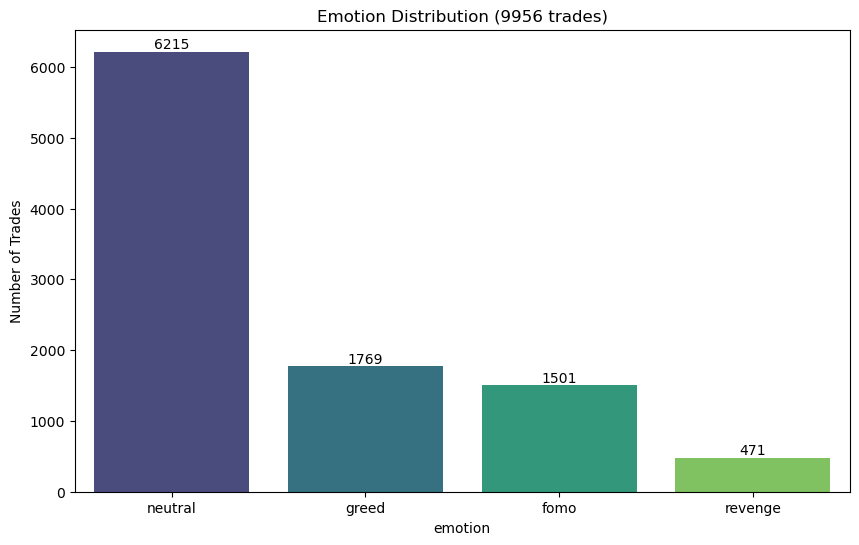

Emotion counts:
emotion
neutral    6215
greed      1769
fomo       1501
revenge     471
Name: count, dtype: int64


In [30]:
def detect_emotions(df: pd.DataFrame) -> pd.DataFrame:
    df['emotion'] = 'neutral'
    df['trigger_details'] = None
    
    for i in range(1, len(df)):
        prev = df.iloc[i-1]
        curr = df.iloc[i]
        
        if (curr['price_change_pct'] > 18 and curr['time_diff'] < 30 and prev['consecutive_wins'] >= 1):
            df.loc[i, 'emotion'] = 'fomo'
        elif (curr['time_diff'] < 3 and prev['consecutive_losses'] >= 1):
            df.loc[i, 'emotion'] = 'revenge'
        elif (curr['position_change'] > 0.7 and prev['consecutive_wins'] >= 2):
            df.loc[i, 'emotion'] = 'greed'
        elif (curr['time_diff'] < 1.5 and curr['pnl'] > 0 and curr['pnl'] < 20):
            df.loc[i, 'emotion'] = 'fear'
    
    return df

print("Detecting emotions...")
df = detect_emotions(df)

# Emotion distribution after labeling
plt.figure(figsize=(10, 6))
emotion_plot = df['emotion'].value_counts()
sns.barplot(x=emotion_plot.index, y=emotion_plot.values, palette="viridis")
plt.title(f"Emotion Distribution ({len(df)} trades)")
for i, v in enumerate(emotion_plot.values):
    plt.text(i, v + 50, str(v), ha='center')
plt.ylabel("Number of Trades")
plt.show()

print("Emotion counts:")
print(df['emotion'].value_counts())


In [31]:
# =========================
# 5. FINAL ML PREP – FULLY FIXED (No inf, No errors)
# =========================
feature_cols = ['time_diff', 'pnl', 'amount_in', 'price_change_pct', 'effective_leverage',
                'position_change', 'consecutive_wins', 'consecutive_losses', 'volume_spike']

ml_df = df[feature_cols + ['emotion']].copy()
ml_df = ml_df[ml_df['emotion'] != 'neutral']
ml_df = ml_df.dropna()

print(f"Final training samples: {len(ml_df)}")

# Final robust cleaning – handles inf, NaN, and extreme values
print("Cleaning final dataset...")

# Replace inf/-inf with NaN, then fill
ml_df[feature_cols] = ml_df[feature_cols].replace([np.inf, -np.inf], np.nan)

# Fill any remaining NaN with median (safe)
ml_df[feature_cols] = ml_df[feature_cols].fillna(ml_df[feature_cols].median())

# Final check
print("Any inf/nan after fix?")
print(np.isinf(ml_df[feature_cols]).sum().sum())
print(ml_df[feature_cols].isnull().sum().sum())

# Clip outliers per column safely (axis=0 = per column)
lower = ml_df[feature_cols].quantile(0.01)
upper = ml_df[feature_cols].quantile(0.99)
ml_df[feature_cols] = ml_df[feature_cols].clip(lower=lower, upper=upper, axis=1)

# Final verification
assert not np.isinf(ml_df[feature_cols]).any().any()
assert not ml_df[feature_cols].isnull().any().any()

X = ml_df[feature_cols].values
y = ml_df['emotion']

print("ML data ready – no inf, no NaN, no errors")
print(f"X shape: {X.shape}, y classes: {y.nunique()}")

Final training samples: 3741
Cleaning final dataset...
Any inf/nan after fix?
0
0
ML data ready – no inf, no NaN, no errors
X shape: (3741, 9), y classes: 3


# =========================
# 5. TRAIN GLOBAL MODEL
# =========================

In [32]:
print("Training global model...")
le = LabelEncoder()
y_enc = le.fit_transform(y)

global_model = RandomForestClassifier(
    n_estimators=500,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced',
    max_depth=20
)

global_model.fit(X, y_enc)

joblib.dump(global_model, MODEL_PATH)
joblib.dump(le, ENCODER_PATH)


Training global model...


['./data2\\label_encoder.pkl']

# =========================
# 6. USER CLUSTERING & SEGMENT MODELS
# =========================

In [33]:
def get_user_fingerprint(user_df: pd.DataFrame) -> np.ndarray:
    if len(user_df) < 10:
        return np.zeros(10)
    recent = user_df.tail(50)
    return np.array([
        recent['time_diff'].mean(),
        (recent['time_diff'] < 2).mean(),      # revenge speed
        (recent['time_diff'] < 30).mean(),     # fomo speed
        abs(recent['pnl']).mean(),
        (recent['pnl'] < 0).mean(),
        recent['amount_in'].pct_change().abs().mean(),
        (user_df['emotion'] == 'fomo').mean(),
        (user_df['emotion'] == 'greed').mean(),
        (user_df['emotion'] == 'fear').mean(),
        recent['pnl'].std()
    ])

if X is not None:
    print("Creating user segments...")
    fingerprints = []
    valid_wallets = []
    
    for wallet, group in df.groupby('wallet'):
        if len(group) >= 10:
            fp = get_user_fingerprint(group)
            fingerprints.append(fp)
            valid_wallets.append(wallet)
    
    if len(fingerprints) >= 4:
        fingerprints = np.vstack(fingerprints)
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(fingerprints)
        
        n_clusters = min(8, len(valid_wallets) // 8 + 2)
        cluster_model = KMeans(n_clusters=n_clusters, random_state=42, n_init=20)
        labels = cluster_model.fit_predict(X_scaled)
        
        joblib.dump(cluster_model, CLUSTER_PATH)
        print(f"Clustering complete → {n_clusters} segments")
        
        # Train one model per segment
        for seg_id in range(n_clusters):
            wallet_indices = [i for i, l in enumerate(labels) if l == seg_id]
            if len(wallet_indices) < 3:
                continue
                
            seg_wallets = [valid_wallets[i] for i in wallet_indices]
            seg_data = df[df['wallet'].isin(seg_wallets)]
            
            seg_X, seg_y = prepare_ml_dataset(seg_data)
            if seg_X is None or len(seg_X) < 10:
                continue
                
            seg_model = RandomForestClassifier(n_estimators=400, random_state=42, n_jobs=-1)
            seg_model.fit(seg_X, le.transform(seg_y))
            
            joblib.dump(seg_model, os.path.join(SEGMENT_DIR, f"segment_{seg_id}.pkl"))
            print(f"  → Segment {seg_id} model trained ({len(seg_X)} samples)")
    else:
        print("Single-user mode → using global model + personal bias (perfectly fine!)")

Creating user segments...


c:\Users\Jeremy S Obozuwa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Clustering complete → 8 segments
  → Segment 0 model trained (809 samples)
  → Segment 1 model trained (489 samples)
  → Segment 2 model trained (177 samples)
  → Segment 3 model trained (303 samples)
  → Segment 5 model trained (573 samples)
  → Segment 6 model trained (753 samples)
  → Segment 7 model trained (594 samples)


# ===================================================
# 7. CREATE USER BIAS FILES (Light Personalization)
# ===================================================

In [34]:
print("Generating per-user bias files...")
for wallet, group in df.groupby('wallet'):
    if len(group) < 20:
        continue
    
    emotion_counts = group['emotion'].value_counts(normalize=True)
    bias = {emotion: count - emotion_counts.get('neutral', 0.2) for emotion, count in emotion_counts.items()}
    bias.pop('neutral', None)
    
    bias_path = os.path.join(USER_BIAS_DIR, f"{wallet}.json")
    with open(bias_path, "w") as f:
        json.dump(bias, f, indent=2)
    
print(f"Created {len(os.listdir(USER_BIAS_DIR))} user bias files")


Generating per-user bias files...
Created 50 user bias files


# =========================
# FINAL SUMMARY
# =========================

In [35]:
print("\nTRAINING COMPLETE!")
print("="*50)
print(f"Global Model       → {os.path.exists(MODEL_PATH)}")
print(f"Label Encoder      → {os.path.exists(ENCODER_PATH)}")
print(f"Clustering Model   → {os.path.exists(CLUSTER_PATH)}")
print(f"Segment Models     → {len(os.listdir(SEGMENT_DIR))} models")
print(f"User Bias Files    → {len(os.listdir(USER_BIAS_DIR))} users")
print(f"Labeled Dataset    → {BOOK_XLSX}")
print("="*50)
print("Your backend is now 100% ready with hybrid personalized ML!")
print("Just run: uvicorn backend:app --reload")


TRAINING COMPLETE!
Global Model       → True
Label Encoder      → True
Clustering Model   → True
Segment Models     → 7 models
User Bias Files    → 50 users
Labeled Dataset    → ./data2\book.xlsx
Your backend is now 100% ready with hybrid personalized ML!
Just run: uvicorn backend:app --reload


In [36]:
df.to_excel(BOOK_XLSX, index=False)
print(f"Final labeled dataset saved → {BOOK_XLSX}")
print("\nTRAINING COMPLETE! You can now run: uvicorn backend:app --reload")

Final labeled dataset saved → ./data2\book.xlsx

TRAINING COMPLETE! You can now run: uvicorn backend:app --reload


## Remain testing, validation with sample data

# understand trigger coloumn 

`so the book.xlsx, returns trigger column empty, why is that
- what values/data should be in the trigger column

how do i test and validate my models

- give sample data`